/tmp/ipykernel_3331200/3025878133.py:110: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, arrowsize=10, edge_color=colors, style="-", width=10, edge_cmap=plt.cm.winter)


Figure Saved:  fig/T1_2160p_time_49_hc.pdf


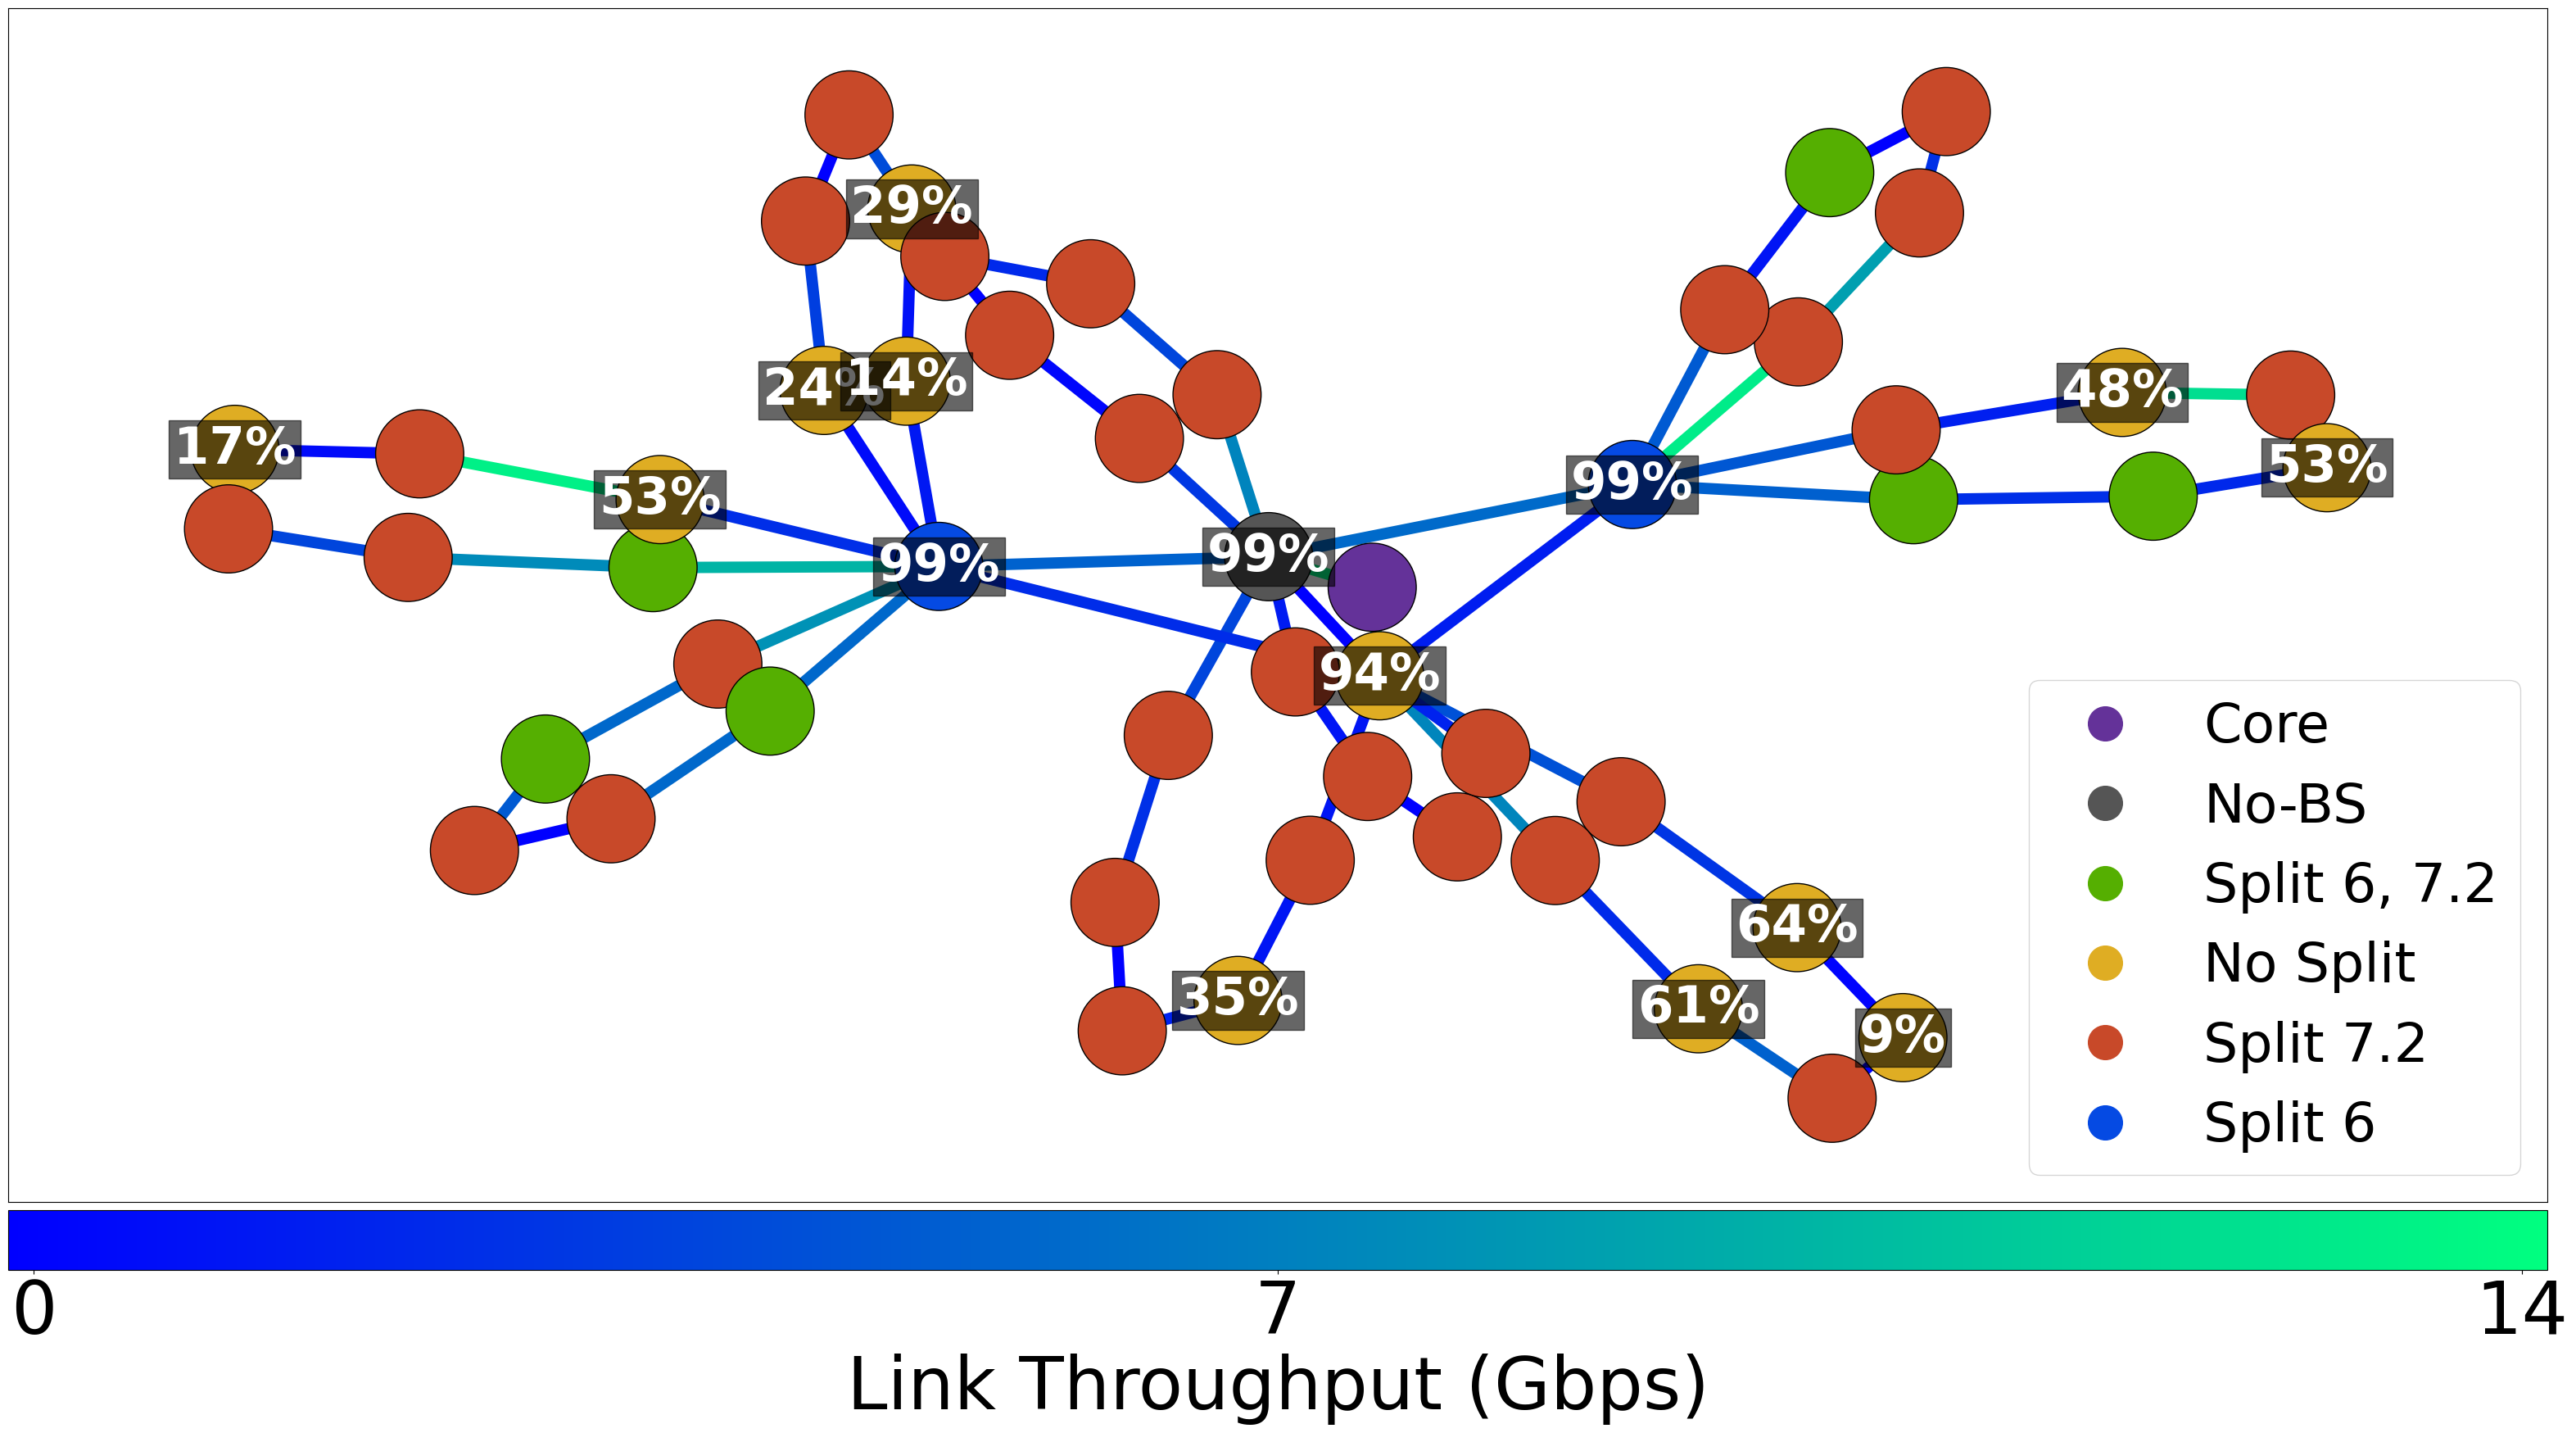

In [2]:
import networkx as nx
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import pandas as pd
import os
from collections import defaultdict
import matplotlib.colors as mcolors

colors = {0:'#643299', 1:'#555555', 4:'#C84929', 3:'#DFAD23', 2:'#55AF01', 5:'#054AE3'}
NODES = "./data/EEPRAN_T1_50_nodes.json"
LINKS = "./data/EEPRAN_T1_50_links.json"
# NET = "./solutions/T1_2160p/topo_50_time_49_network.csv"
# HW =  "./solutions/T1_2160p/topo_50_time_49_hw.csv"
# BS =  "./solutions/T1_2160p/topo_50_time_49_drc_per_bs.csv"

NET = "./solutions/test/topo_50_time_32_network.csv"
HW =  "./solutions/test/topo_50_time_32_hw.csv"
BS =  "./solutions/test/topo_50_time_32_drc_per_bs.csv"

p = "fig/T1_2160p_time_49_hc.pdf"

drcs = {-2: "No-BS", -1: "Core", 0: "No Split", 9: "Split 7.2", 62: "Split 6", 6: "Split 6, 7.2"}
mod = "sfdp"
max_link_usage = 16.78
x_ = 40
y_ = 20
    
def read_nodes_links(nodes, links):
    delays = {}
    capacities = {}
    usages = defaultdict(int)
    with open(links) as json_file:
        data_l = json.load(json_file)
    
    for l in data_l['links']:
        delays[(l['Node1'], l['Node2'])] = l['Delay']
        capacities[(int(l['Node1']), int(l['Node2']))] = l['PortCapacity']*l['NumLinks']
    
    df = pd.read_csv(NET)
    for idx, line in df.iterrows():
        if line['node1'] == line['node2']:
            continue
        n1 = int(line['node1'])
        n2 = int(line['node2'])
        if (n1, n2) in delays.keys():
            usages[(n1, n2)] = line['usage']
        else:
            usages[(n2, n1)] = line['usage']
    
    links = [(link, delays[link], usages[link], capacities[link]) for link in delays.keys()]

    with open(nodes) as json_file:
        data_n = json.load(json_file)
        
    df_hw = pd.read_csv(HW)
    hw_usage = defaultdict(float)
    for idx, line in df_hw.iterrows():
        hw_usage[line['hw']] = line['usage']
    
    df_bs = pd.read_csv(BS)
    bs_drc = {0: "Core"}
    for idx, line in df_bs.iterrows():
        bs_drc[int(line['bs'])] = drcs[int(line['drc'])]
    
    for n in data_n['nodes']:
        if int(n['Number']) not in bs_drc.keys():
            bs_drc[int(n['Number'])] = drcs[-2]
        
    nodes = [(n['Number'], bs_drc[int(n['Number'])], hw_usage[n['Number']], 180) for n in data_n['nodes']]

    return nodes, links


def colors_rc(nodes):
    cores = [n[1] for n in nodes]
    cl = {}
    core_labels = list(dict.fromkeys(cores))
    # core_labels.sort()
    for item in range(len(core_labels)):
        cl[core_labels[item]] = colors[item]
    for item in range(len(cores)):
        cores[item] = cl[cores[item]]
    return cl, cores


def plot_graph(nodes, links, mod, x_, y_):

    nodes, links = read_nodes_links(nodes, links)
    
    G = nx.Graph()
    G.add_nodes_from([n[0] for n in nodes])
    
    core_labels, core_colors = colors_rc(nodes)

    for link, delay, usg, cap  in links:
        G.add_edge(link[0], link[1], weight="[{:.4f} / {} gbps]".format(usg, cap), color=mcolors.to_hex(plt.cm.winter(usg/14)))

    fig, ax = plt.subplots()
    fig.set_size_inches(x_, y_)

    pos = nx.nx_agraph.graphviz_layout(G, prog=mod)
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nodes_graph = nx.draw_networkx_nodes(G, pos, node_size=6000, node_color=core_colors, edgecolors='#000000')
    colors = nx.get_edge_attributes(G,'color').values()
    
    edges = nx.draw_networkx_edges(G, pos, arrowsize=10, edge_color=colors, style="-", width=10, edge_cmap=plt.cm.winter)
    
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, font_color='#ff5050', font_size=10)
    lpos = {}
    labels = {}
    for node in nodes:
        if float(node[2]) == 0.0:
            continue
        num = node[0]
        lpos[num] = (pos[num][0], pos[num][1])
        labels[num] = "{}%".format(int(float(node[2])/float(node[3])*100))
    label_options = {"ec": "k", "fc": "black", "alpha": 0.6}
    nx.draw_networkx_labels(G, lpos, labels, font_color="white", font_weight="bold", bbox=label_options, font_size=45)
    
    plist = []
    for item in core_labels:
        pl, = (ax.plot([], [], "o", label=str(item), color=str(core_labels[item])))
        plist.append(pl)
    ax.legend(handles=plist, fontsize=48, loc='lower right', markerscale=5)
    
    for node, (x, y) in pos.items():
        text(x, y, "", fontsize=30, ha='center', va='center', color='#ffffff')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    cbar = fig.colorbar(edges, ticks=[0.01, 0.5, 0.99], format=matplotlib.ticker.FixedFormatter(['0', '7', '14']), 
                        orientation='horizontal', cax=cax)
    cbar.ax.tick_params(labelsize=64, labeltop=False, top=False, labelbottom=True, bottom=True)
    cbar.set_label(label="Link Throughput (Gbps)", size=64)
    
    # plt.title("eMBB 1440p - Timestamp 30")
    plt.savefig(p, bbox_inches='tight')
    print("Figure Saved: ", p)
    
    
    #plt.show()

if __name__ == '__main__':
    plot_graph(NODES, LINKS, mod, x_, y_)

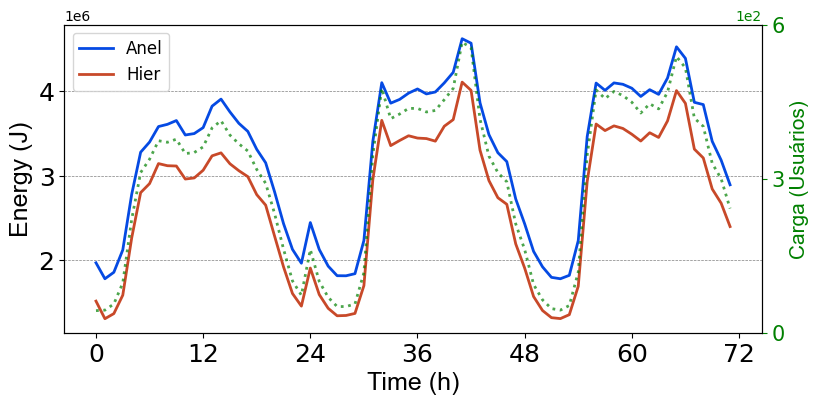

In [64]:
import pandas
import os
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------


df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50.csv", sep=',')
df_t2 = pandas.read_csv(r"solutions\2160p\topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Energy (J)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Time (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

df_t1['energy'] = df_t1['ranEnergy'] + df_t1['migEnergy'] + df_t1['netEnergy']
df_t2['energy'] = df_t2['ranEnergy'] + df_t2['migEnergy'] + df_t2['netEnergy']

ax1.plot(df_t1['timestamp'][:72], df_t1['energy'][:72], lw=2, color=color2, label='Anel')
ax1.plot(df_t2['timestamp'][:72], df_t2['energy'][:72], lw=2, color=color3, label='Hier')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# ------------
# SCATTER PLOT
# ------------

df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
ax2 = ax1.twinx()
ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')

ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
ax2.tick_params(axis='x', which='major', labelsize=15)
# ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax2.plot(df_t1['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')

plt.yticks([0, 300, 600])
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
# plt.title("Energia Total da Solução")
# plt.savefig('fig/energy.pdf', bbox_inches='tight')

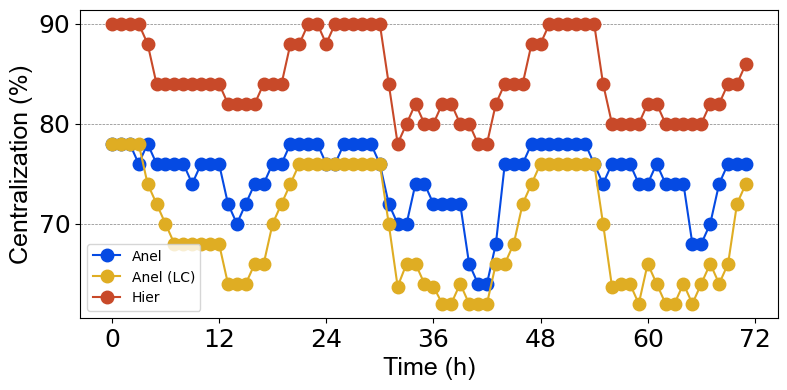

In [71]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50.csv", sep=',')
df_t2 = pandas.read_csv(r"solutions\2160p\topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization (%)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Time (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t1['timestamp'][:72], df_t1['centralization'][:72]/3.5, color=color2, marker='o', ms=9, label='Anel')
ax1.plot(df_t1_lc['timestamp'][:72], df_t1_lc['centralization'][:72]/3.5, color=color4, marker='o', ms=9, label='Anel (LC)')
ax1.plot(df_t2['timestamp'][:72], df_t2['centralization'][:72]/3.5, color=color3, marker='o', ms=9, label='Hier')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

plt.savefig('fig/centralization_service.pdf', bbox_inches='tight')


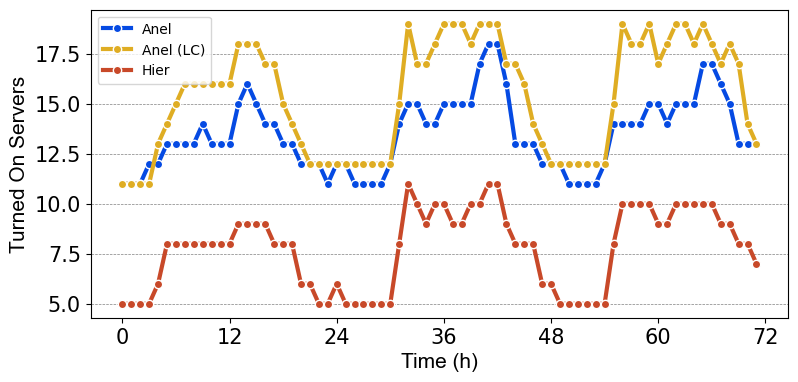

In [78]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50.csv", sep=',')
df_t2 = pandas.read_csv(r"solutions\2160p\topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Turned On Servers', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Time (h)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.plot(df_t1['timestamp'][:72], df_t1['usedMachines'][:72], color=color2, lw=3, marker="o", mec="White", label='Anel')
ax1.plot(df_t1_lc['timestamp'][:72], df_t1_lc['usedMachines'][:72], color=color4, lw=3, marker="o", mec="White", label='Anel (LC)')
ax1.plot(df_t2['timestamp'][:72], df_t2['usedMachines'][:72], color=color3, lw=3, marker="o", mec="White", label='Hier')
    
# plt.yticks([0, 2000000])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
# plt.title("Quantidade de Servidores Ligados")
plt.savefig('fig/used_machines.pdf', bbox_inches='tight')


Text(0.5, 1.0, 'Energia Total da Solução')

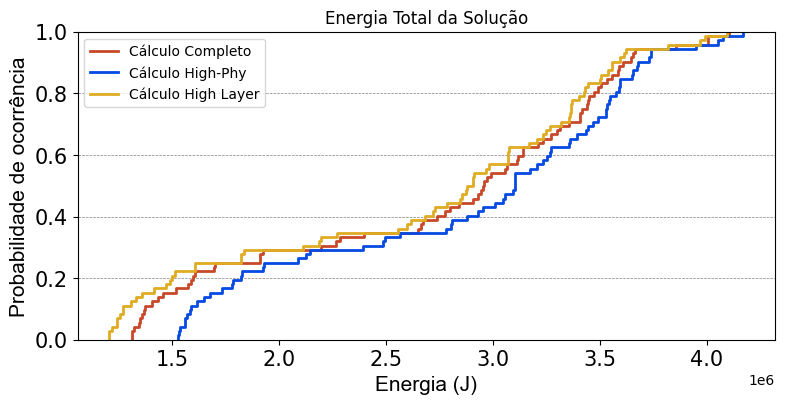

In [11]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_calc = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')
df_hp = pandas.read_csv("solutions/hp_2160p/topo_50.csv", sep=',')
df_hl = pandas.read_csv("solutions/hl_2160p/topo_50.csv", sep=',')


fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Probabilidade de ocorrência', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Energia (J)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

df_calc['energy'] = df_calc['ranEnergy'] + df_calc['migEnergy'] + df_calc['netEnergy']
df_hp['energy'] = df_hp['ranEnergy'] + df_hp['migEnergy'] + df_hp['netEnergy']
df_hl['energy'] = df_hl['ranEnergy'] + df_hl['migEnergy'] + df_hl['netEnergy']

ax1.ecdf(df_calc['energy'][:72], color=color3, lw=2, label="Cálculo Completo")
ax1.ecdf(df_hp['energy'][:72], color=color2, lw=2, label='Cálculo High-Phy')
ax1.ecdf(df_hl['energy'][:72], color=color4, lw=2, label='Cálculo High Layer')
# ax1.hist(df_calc['energy'], 10, density=True, histtype="step", cumulative=True, label="Cumulative hist")

# ax1.plot(df_calc['timestamp'][:72], df_calc['energy'][:72], color=color3, label='Cálculo Completo')
# ax1.plot(df_hp['timestamp'][:72], df_hp['energy'][:72], color=color2, label='Cálculo High-Phy')
# ax1.plot(df_hl['timestamp'][:72], df_hl['energy'][:72], color=color4, label='Cálculo High Layer')

# plt.yticks([0, 2000000])
# plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left')

# ------------
# SCATTER PLOT
# ------------

# df = pandas.read_csv("data/T2_50_BS_usage.csv", sep=',')
# ax2 = ax1.twinx()
# ax2.set_ylabel('Carga (Usuários)', color='green', fontsize=15, fontfamily='Arial')
# 
# ax2.tick_params(axis='y', which='major', colors='green', labelsize=15)
# ax2.tick_params(axis='x', which='major', labelsize=15)
# # ax2.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
# 
# ax2.plot(df_urllc['timestamp'][:72], df.sum(axis=1)[:72], color='green', lw=2, alpha=alpha, linestyle=':')
# 
# plt.yticks([0, 300, 600])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

# plt.show()
plt.title("Energia Total da Solução")
# plt.savefig('fig/energy_calc.pdf', bbox_inches='tight')

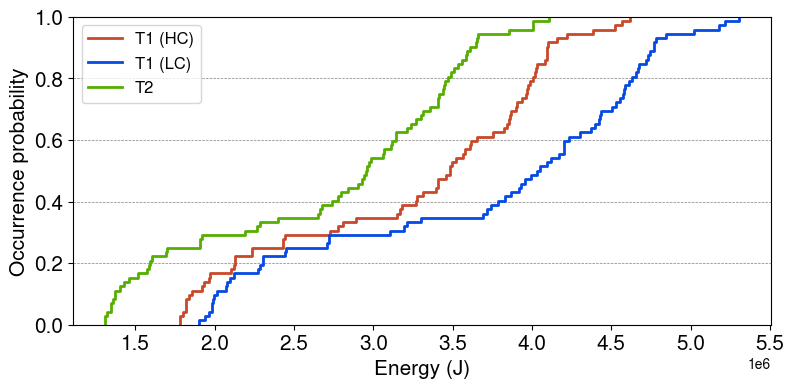

In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')
df_t2 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1['energy'] = df_t1['ranEnergy'] + df_t1['migEnergy'] + df_t1['netEnergy']
df_t1_lc['energy'] = df_t1_lc['ranEnergy'] + df_t1_lc['migEnergy'] + df_t1_lc['netEnergy']
df_t2['energy'] = df_t2['ranEnergy'] + df_t2['migEnergy'] + df_t2['netEnergy']

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Occurrence probability', fontsize=15)
ax1.set_xlabel('Energy (J)', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.ecdf(df_t1['energy'][:72], color=color3, lw=2, label="T1 (HC)")
ax1.ecdf(df_t1_lc['energy'][:72], color=color2, lw=2, label="T1 (LC)")
ax1.ecdf(df_t2['energy'][:72], color=color5, lw=2, label='T2')

plt.legend(loc='upper left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_complete_topologies.pdf', bbox_inches='tight')

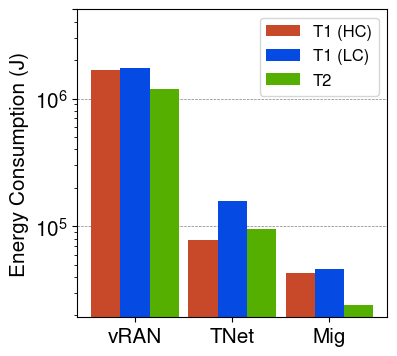

In [4]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')
df_t2 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

energy_components = ['vRAN', 'TNet', 'Mig']
topologies = {
    'T1 (HC)': np.array([df_t1['ranEnergy'][52], df_t1['netEnergy'][52], df_t1['migEnergy'][52]]), 
    'T1 (LC)': np.array([df_t1_lc['ranEnergy'][52], df_t1_lc['netEnergy'][52], df_t1_lc['migEnergy'][52]]),
    'T2': np.array([df_t2['ranEnergy'][52], df_t2['netEnergy'][52], df_t2['migEnergy'][52]]),
}

x = np.arange(len(energy_components))
width = 0.3
multiplier = 0
color_idx = 1

fig, ax1 = plt.subplots(figsize=(4, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

colors = [color1, color3, color2, color5, color5]

alpha = 0.7
ax1.set_ylabel('Energy Consumption (J)', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_yscale('log')

for topology, energy in topologies.items():
    offset = width * multiplier
    bar = ax1.bar(x + offset, energy, width, color=colors[color_idx], label=topology)
    ax1.set_xticks(x + width, energy_components)
    multiplier += 1
    color_idx += 1


ax1.set_yticks([100000, 1000000, 5000000])
s_axis = ax1.get_ylim()
plt.legend(loc='upper right', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_components_topo_low.pdf', bbox_inches='tight')

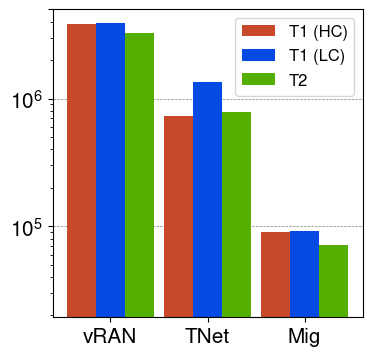

In [6]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')
df_t2 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

energy_components = ['vRAN', 'TNet', 'Mig']
topologies = {
    'T1 (HC)': np.array([df_t1['ranEnergy'][41], df_t1['netEnergy'][41], df_t1['migEnergy'][41]]),
    'T1 (LC)': np.array([df_t1_lc['ranEnergy'][41], df_t1_lc['netEnergy'][41], df_t1_lc['migEnergy'][41]]),
    'T2': np.array([df_t2['ranEnergy'][41], df_t2['netEnergy'][41], df_t2['migEnergy'][41]]),
}

x = np.arange(len(energy_components))
width = 0.3
multiplier = 0
color_idx = 1

fig, ax1 = plt.subplots(figsize=(4, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

colors = [color1, color3, color2, color5, color5]

alpha = 0.7
# ax1.set_ylabel('Energy Consumption (J)', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_yscale('log')

for topology, energy in topologies.items():
    offset = width * multiplier
    bar = ax1.bar(x + offset, energy, width, color=colors[color_idx], label=topology)
    ax1.set_xticks(x + width, energy_components)
    multiplier += 1
    color_idx += 1

ax1.set_yticks([100000, 1000000, 5000000])
plt.legend(loc='upper right', fontsize=12)
ax1.set_ylim(s_axis)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_components_topo_high.pdf', bbox_inches='tight')

# Profiles

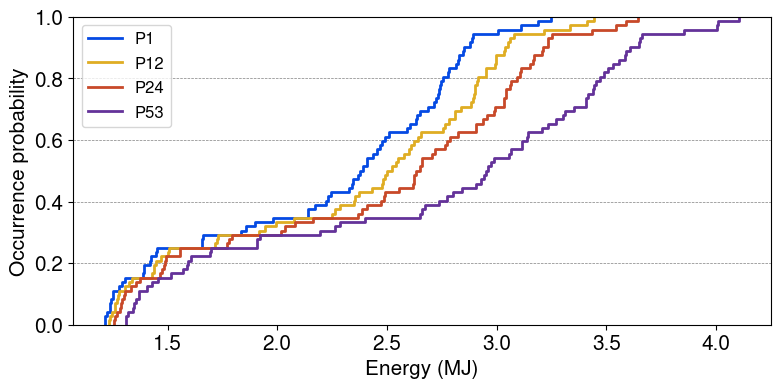

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_p1 = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_p12 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_p24 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_p53 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_p1['energy'] = df_p1['ranEnergy'] + df_p1['migEnergy'] + df_p1['netEnergy']
df_p12['energy'] = df_p12['ranEnergy'] + df_p12['migEnergy'] + df_p12['netEnergy']
df_p24['energy'] = df_p24['ranEnergy'] + df_p24['migEnergy'] + df_p24['netEnergy']
df_p53['energy'] = df_p53['ranEnergy'] + df_p53['migEnergy'] + df_p53['netEnergy']

# df_p1['energy'] = df_p1['ranEnergy']
# df_p12['energy'] = df_p12['ranEnergy']
# df_p24['energy'] = df_p24['ranEnergy']
# df_p53['energy'] = df_p53['ranEnergy']

# df_p1['energy'] = df_p1['netEnergy']
# df_p12['energy'] = df_p12['netEnergy']
# df_p24['energy'] = df_p24['netEnergy']
# df_p53['energy'] = df_p53['netEnergy']

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Occurrence probability', fontsize=15)
ax1.set_xlabel('Energy (MJ)', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.ecdf(df_p1['energy'][:72]/1e6, color=color2, lw=2, label="P1")
ax1.ecdf(df_p12['energy'][:72]/1e6, color=color4, lw=2, label="P12")
ax1.ecdf(df_p24['energy'][:72]/1e6, color=color3, lw=2, label='P24')
ax1.ecdf(df_p53['energy'][:72]/1e6, color=color1, lw=2, label='P53')

plt.legend(loc='upper left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_complete_usage_profile.pdf', bbox_inches='tight')

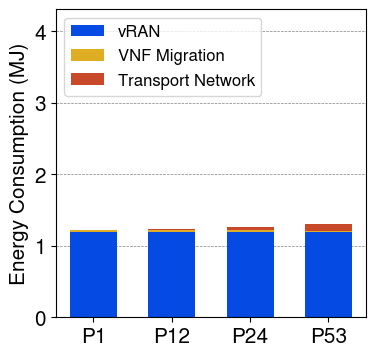

In [6]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_p1 = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_p12 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_p24 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_p53 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_p1['ranEnergy'] = df_p1['ranEnergy']/1e6 
df_p1['migEnergy'] = df_p1['migEnergy']/1e6 
df_p1['netEnergy'] = df_p1['netEnergy']/1e6

df_p12['ranEnergy'] = df_p12['ranEnergy']/1e6 
df_p12['migEnergy'] = df_p12['migEnergy']/1e6 
df_p12['netEnergy'] = df_p12['netEnergy']/1e6

df_p24['ranEnergy'] = df_p24['ranEnergy']/1e6 
df_p24['migEnergy'] = df_p24['migEnergy']/1e6 
df_p24['netEnergy'] = df_p24['netEnergy']/1e6

df_p53['ranEnergy'] = df_p53['ranEnergy']/1e6 
df_p53['migEnergy'] = df_p53['migEnergy']/1e6 
df_p53['netEnergy'] = df_p53['netEnergy']/1e6

df_p1['energy'] = df_p1['ranEnergy'] + df_p1['migEnergy'] + df_p1['netEnergy']
df_p12['energy'] = df_p12['ranEnergy'] + df_p12['migEnergy'] + df_p12['netEnergy']
df_p24['energy'] = df_p24['ranEnergy'] + df_p24['migEnergy'] + df_p24['netEnergy']
df_p53['energy'] = df_p53['ranEnergy'] + df_p53['migEnergy'] + df_p53['netEnergy']

profiles = ['P1', 'P12', 'P24', 'P53']
energies = {
    'vRAN': np.array([df_p1['ranEnergy'][52], df_p12['ranEnergy'][52], df_p24['ranEnergy'][52], df_p53['ranEnergy'][52]]),
    'VNF Migration': np.array([df_p1['migEnergy'][52], df_p12['migEnergy'][52], df_p24['migEnergy'][52], df_p53['migEnergy'][52]]),
    'Transport Network': np.array([df_p1['netEnergy'][52], df_p12['netEnergy'][52], df_p24['netEnergy'][52], df_p53['netEnergy'][52]]),
}
width = 0.6
bottom = np.zeros(4)
color_idx = 1

fig, ax1 = plt.subplots(figsize=(4, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

colors = [color1, color2, color4, color3, color5]

alpha = 0.7
ax1.set_ylabel('Energy Consumption (MJ)', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

for energy_src, energy in energies.items():
    bar = ax1.bar(profiles, energy, width, color=colors[color_idx], label=energy_src, bottom=bottom)
    bottom += energy
    color_idx += 1

ax1.set_ylim(0.0, 4310650.35216596/1e6)
plt.legend(loc='upper left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_components_low.pdf', bbox_inches='tight')

(0.0, 4.31065035216596)


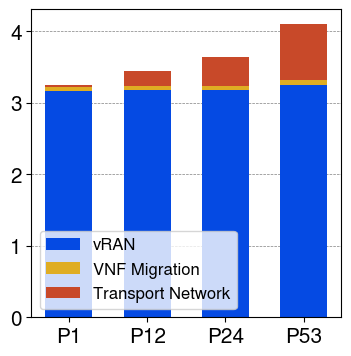

In [5]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_p1 = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_p12 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_p24 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_p53 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_p1['ranEnergy'] = df_p1['ranEnergy']/1e6 
df_p1['migEnergy'] = df_p1['migEnergy']/1e6 
df_p1['netEnergy'] = df_p1['netEnergy']/1e6

df_p12['ranEnergy'] = df_p12['ranEnergy']/1e6 
df_p12['migEnergy'] = df_p12['migEnergy']/1e6 
df_p12['netEnergy'] = df_p12['netEnergy']/1e6

df_p24['ranEnergy'] = df_p24['ranEnergy']/1e6 
df_p24['migEnergy'] = df_p24['migEnergy']/1e6 
df_p24['netEnergy'] = df_p24['netEnergy']/1e6

df_p53['ranEnergy'] = df_p53['ranEnergy']/1e6 
df_p53['migEnergy'] = df_p53['migEnergy']/1e6 
df_p53['netEnergy'] = df_p53['netEnergy']/1e6

df_p1['energy'] = df_p1['ranEnergy'] + df_p1['migEnergy'] + df_p1['netEnergy']
df_p12['energy'] = df_p12['ranEnergy'] + df_p12['migEnergy'] + df_p12['netEnergy']
df_p24['energy'] = df_p24['ranEnergy'] + df_p24['migEnergy'] + df_p24['netEnergy']
df_p53['energy'] = df_p53['ranEnergy'] + df_p53['migEnergy'] + df_p53['netEnergy']

profiles = ['P1', 'P12', 'P24', 'P53']
energies = {
    'vRAN': np.array([df_p1['ranEnergy'][41], df_p12['ranEnergy'][41], df_p24['ranEnergy'][41], df_p53['ranEnergy'][41]]),
    'VNF Migration': np.array([df_p1['migEnergy'][41], df_p12['migEnergy'][41], df_p24['migEnergy'][41], df_p53['migEnergy'][41]]),
    'Transport Network': np.array([df_p1['netEnergy'][41], df_p12['netEnergy'][41], df_p24['netEnergy'][41], df_p53['netEnergy'][41]]),
}
width = 0.6
bottom = np.zeros(4)
color_idx = 1

fig, ax1 = plt.subplots(figsize=(4, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

colors = [color1, color2, color4, color3, color5]

alpha = 0.7
# ax1.set_ylabel('Energy Consumption', fontsize=15)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

for energy_src, energy in energies.items():
    bar = ax1.bar(profiles, energy, width, color=colors[color_idx], label=energy_src, bottom=bottom)
    bottom += energy
    color_idx += 1

print(ax1.get_ylim())
plt.legend(loc='lower left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
plt.savefig('fig/energy_components_high.pdf', bbox_inches='tight')

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50.csv", sep=',')
df_t1_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50.csv", sep=',')
df_t2 = pandas.read_csv(r"solutions\2160p\topo_50.csv", sep=',')

df_t1['energy'] = df_t1['ranEnergy'] + df_t1['migEnergy'] + df_t1['netEnergy']
df_t1_lc['energy'] = df_t1_lc['ranEnergy'] + df_t1_lc['migEnergy'] + df_t1_lc['netEnergy']
df_t2['energy'] = df_t2['ranEnergy'] + df_t2['migEnergy'] + df_t2['netEnergy']

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Occurrence probability', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Energy (J)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax1.ecdf(df_t1['netEnergy'][:72], color=color2, lw=2, label="T1 (HC)")
ax1.ecdf(df_t1_lc['netEnergy'][:72], color=color4, lw=2, label="T1 (LC)")
ax1.ecdf(df_t2['netEnergy'][:72], color=color3, lw=2, label='T2')

plt.legend(loc='upper left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
# plt.savefig('fig/energy_calc.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'solutions\\T1_2160p\\topo_50.csv'

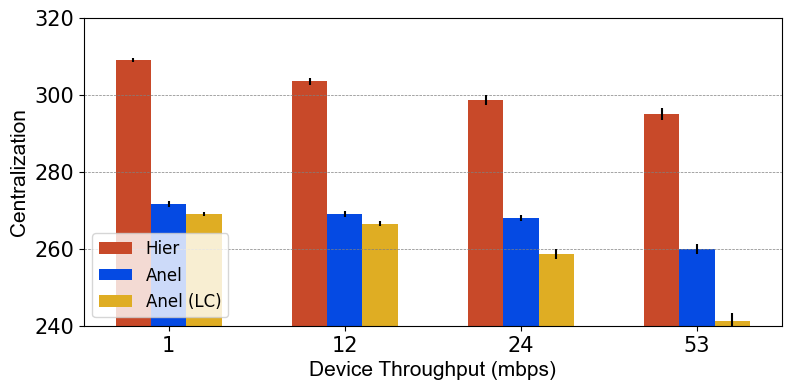

In [55]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

def stderr(arr):
    return np.std(arr)/np.sqrt(len(arr))
    
# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv(r"solutions\urllc\topo_50.csv", sep=',')
df_t2_1080 = pandas.read_csv(r"solutions\1080p\topo_50.csv", sep=',')
df_t2_1440 = pandas.read_csv(r"solutions\1440p\topo_50.csv", sep=',')
df_t2_2160 = pandas.read_csv(r"solutions\2160p\topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv(r"solutions\T1_urllc\topo_50.csv", sep=',')
df_t1_1080 = pandas.read_csv(r"solutions\T1_1080p\topo_50.csv", sep=',')
df_t1_1440 = pandas.read_csv(r"solutions\T1_1440p\topo_50.csv", sep=',')
df_t1_2160 = pandas.read_csv(r"solutions\T1_2160p\topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv(r"solutions\T1_LC_urllc\topo_50.csv", sep=',')
df_t1_1080_lc = pandas.read_csv(r"solutions\T1_LC_1080p\topo_50.csv", sep=',')
df_t1_1440_lc = pandas.read_csv(r"solutions\T1_LC_1440p\topo_50.csv", sep=',')
df_t1_2160_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50.csv", sep=',')

t2_means = [np.mean(df_t2_urllc['centralization']), np.mean(df_t2_1080['centralization']), np.mean(df_t2_1440['centralization']), np.mean(df_t2_2160['centralization'])]
t2_sterr = [stderr(df_t2_urllc['centralization']), stderr(df_t2_1080['centralization']), stderr(df_t2_1440['centralization']), stderr(df_t2_2160['centralization'])]

t1_means = [np.mean(df_t1_urllc['centralization']), np.mean(df_t1_1080['centralization']), np.mean(df_t1_1440['centralization']), np.mean(df_t1_2160['centralization'])]
t1_sterr = [stderr(df_t1_urllc['centralization']), stderr(df_t1_1080['centralization']), stderr(df_t1_1440['centralization']), stderr(df_t1_2160['centralization'])]

t1_lc_means = [np.mean(df_t1_urllc_lc['centralization']), np.mean(df_t1_1080_lc['centralization']), np.mean(df_t1_1440_lc['centralization']), np.mean(df_t1_2160_lc['centralization'])]
t1_lc_sterr = [stderr(df_t1_urllc_lc['centralization']), stderr(df_t1_1080_lc['centralization']), stderr(df_t1_1440_lc['centralization']), stderr(df_t1_2160_lc['centralization'])]

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'
alpha = 0.7

N = len(t2_means)
ind = np.arange(N)
width = 0.2

ax1.bar(ind - width, t2_means, width, bottom=0, yerr=t2_sterr, color=color3, label="Hier")
ax1.bar(ind, t1_means, width, bottom=0, yerr=t1_sterr, color=color2, label="Anel")
ax1.bar(ind + width, t1_lc_means, width, bottom=0, yerr=t1_lc_sterr, color=color4, label="Anel (LC)")

ax1.set_ylabel('Centralization', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Device Throughput (mbps)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
plt.xticks([0, 1, 2, 3], ['1', '12', '24', '53'])
plt.ylim(240, 320)

plt.legend(loc='lower left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
# plt.savefig('fig/energy_calc.pdf', bbox_inches='tight')

(70.99499999999973, 90.90500000000003)


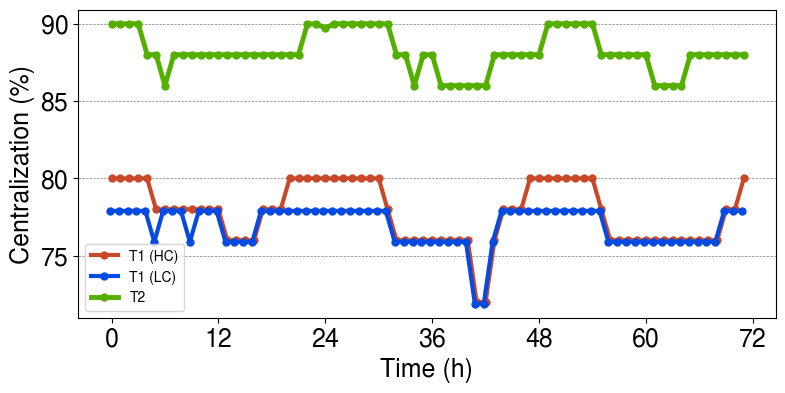

In [8]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_1080 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_t2_1440 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_t2_2160 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_1080 = pandas.read_csv("solutions/T1_1080p/topo_50.csv", sep=',')
df_t1_1440 = pandas.read_csv("solutions/T1_1440p/topo_50.csv", sep=',')
df_t1_2160 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_1080_lc = pandas.read_csv("solutions/T1_LC_1080p/topo_50.csv", sep=',')
df_t1_1440_lc = pandas.read_csv("solutions/T1_LC_1440p/topo_50.csv", sep=',')
df_t1_2160_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t1_urllc['timestamp'][:72], df_t1_urllc['centralization'][:72]/3.5, color=color3, lw=3, marker='o', ms=5, label='T1 (HC)')
ax1.plot(df_t1_urllc_lc['timestamp'][:72] - 0.2, df_t1_urllc_lc['centralization'][:72]/3.5 - 0.1, color=color2, lw=3, marker='o', ms=5, label='T1 (LC)')
ax1.plot(df_t2_urllc['timestamp'][:72], df_t2_urllc['centralization'][:72]/3.5, color=color5, lw=3.5, marker='o', ms=5, label='T2')

plt.xticks(range(0, 74, 12))
print(ax1.get_ylim())
plt.legend(loc='lower left')

# plt.show()
# plt.title("Centralização por Tipo de Serviço")
plt.savefig('fig/centralization_topologies.pdf', bbox_inches='tight')


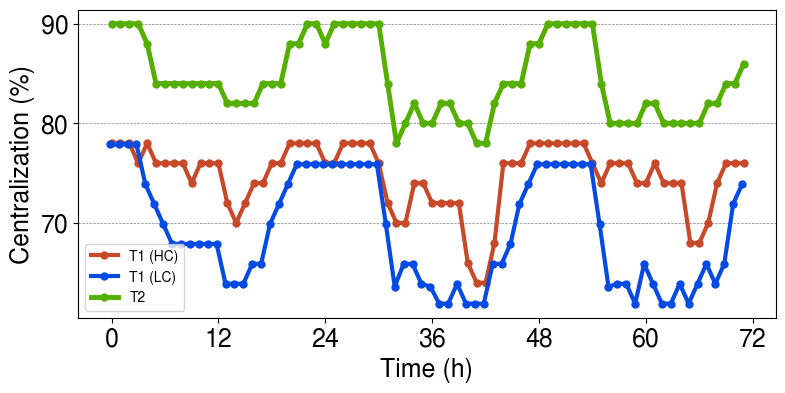

In [91]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='Nimbus Sans') 
plt.rc('axes', axisbelow=True)

# ---------
# LINE PLOT
# ---------

df_t2_p1 = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_p12 = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_t2_p24 = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_t2_p53 = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_p1 = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_p12 = pandas.read_csv("solutions/T1_1080p/topo_50.csv", sep=',')
df_t1_p24 = pandas.read_csv("solutions/T1_1440p/topo_50.csv", sep=',')
df_t1_p53 = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_p1_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_p12_lc = pandas.read_csv("solutions/T1_LC_1080p/topo_50.csv", sep=',')
df_t1_p24_lc = pandas.read_csv("solutions/T1_LC_1440p/topo_50.csv", sep=',')
df_t1_p53_lc = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Centralization (%)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(df_t1_p53['timestamp'][:72], df_t1_p53['centralization'][:72]/3.5, color=color3, lw=3, marker='o', ms=5, label='T1 (HC)')
ax1.plot(df_t1_p53_lc['timestamp'][:72] - 0.2, df_t1_p53_lc['centralization'][:72]/3.5 - 0.1, color=color2, lw=3, marker='o', ms=5, label='T1 (LC)')
ax1.plot(df_t2_p53['timestamp'][:72], df_t2_p53['centralization'][:72]/3.5, color=color5, lw=3.5, marker='o', ms=5, label='T2')

plt.xticks(range(0, 74, 12))
plt.legend(loc='lower left')

# plt.show()
# plt.title("Centralização por Tipo de Serviço")
plt.savefig('fig/centralization_topologies_p53.pdf', bbox_inches='tight')


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


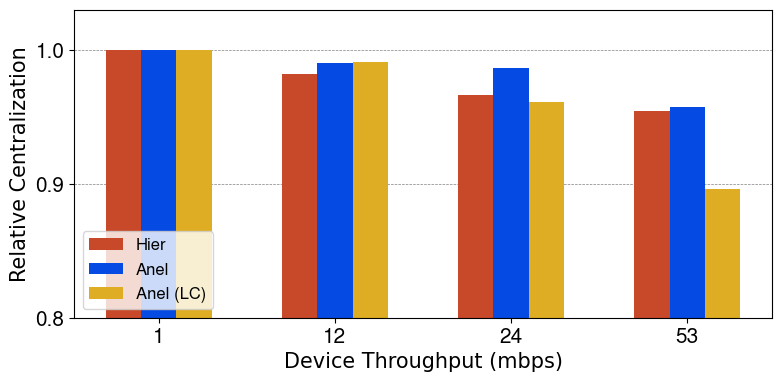

In [7]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

def stderr(arr):
    return np.std(arr)/np.sqrt(len(arr))
    
# ---------
# LINE PLOT
# ---------

df_t2_urllc = pandas.read_csv("solutions/urllc/topo_50.csv", sep=',')
df_t2_1080  = pandas.read_csv("solutions/1080p/topo_50.csv", sep=',')
df_t2_1440  = pandas.read_csv("solutions/1440p/topo_50.csv", sep=',')
df_t2_2160  = pandas.read_csv("solutions/2160p/topo_50.csv", sep=',')

df_t1_urllc = pandas.read_csv("solutions/T1_urllc/topo_50.csv", sep=',')
df_t1_1080  = pandas.read_csv("solutions/T1_1080p/topo_50.csv", sep=',')
df_t1_1440  = pandas.read_csv("solutions/T1_1440p/topo_50.csv", sep=',')
df_t1_2160  = pandas.read_csv("solutions/T1_2160p/topo_50.csv", sep=',')

df_t1_urllc_lc = pandas.read_csv("solutions/T1_LC_urllc/topo_50.csv", sep=',')
df_t1_1080_lc  = pandas.read_csv("solutions/T1_LC_1080p/topo_50.csv", sep=',')
df_t1_1440_lc  = pandas.read_csv("solutions/T1_LC_1440p/topo_50.csv", sep=',')
df_t1_2160_lc  = pandas.read_csv("solutions/T1_LC_2160p/topo_50.csv", sep=',')

t2_ref = np.mean(df_t2_urllc['centralization'])
t2_means = [1.0, np.mean(df_t2_1080['centralization'])/t2_ref, np.mean(df_t2_1440['centralization'])/t2_ref, np.mean(df_t2_2160['centralization'])/t2_ref]
t1_ref = np.mean(df_t1_urllc['centralization'])
t1_means = [1.0, np.mean(df_t1_1080['centralization'])/t1_ref, np.mean(df_t1_1440['centralization'])/t1_ref, np.mean(df_t1_2160['centralization'])/t1_ref]
t1_lc_ref = np.mean(df_t1_urllc_lc['centralization'])
t1_lc_means = [1.0, np.mean(df_t1_1080_lc['centralization'])/t1_lc_ref, np.mean(df_t1_1440_lc['centralization'])/t1_lc_ref, np.mean(df_t1_2160_lc['centralization'])/t1_lc_ref]

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'
alpha = 0.7

N = len(t2_means)
ind = np.arange(N)
width = 0.2

ax1.bar(ind - width, t2_means, width, bottom=0, color=color3, label="Hier")
ax1.bar(ind, t1_means, width, bottom=0, color=color2, label="Anel")
ax1.bar(ind + width, t1_lc_means, width, bottom=0, color=color4, label="Anel (LC)")

ax1.set_ylabel('Relative Centralization', fontsize=15, fontfamily='Arial')
ax1.set_xlabel('Device Throughput (mbps)', fontsize=15, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
plt.xticks([0, 1, 2, 3], ['1', '12', '24', '53'])
plt.yticks([0.8, 0.9, 1.0])
plt.ylim(0.8, 1.03)

plt.legend(loc='lower left', fontsize=12)

# plt.show()
# plt.title("Energia Total da Solução")
# plt.savefig('fig/energy_calc.pdf', bbox_inches='tight')

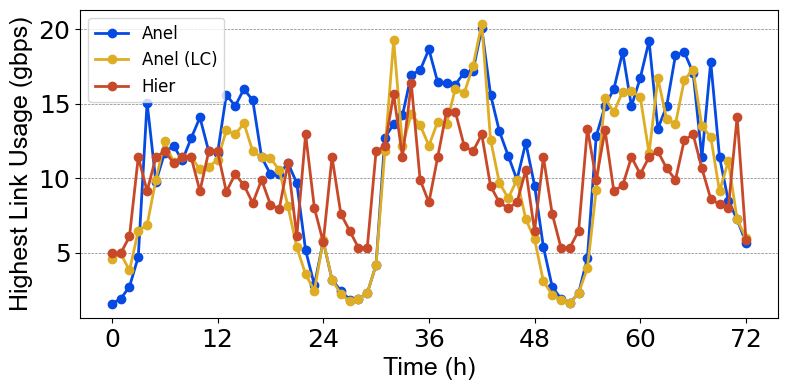

In [50]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

t1_net = []
t1_lc_net = []
t2_net = []

for timestamp in range(0, 73):
    df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    df_t1_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    df_t2 = pandas.read_csv(r"solutions\2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    
    t1_net.append(df_t1['usage'].max())
    t1_lc_net.append(df_t1_lc['usage'].max())
    t2_net.append(df_t2['usage'].max())

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Highest Link Usage (gbps)', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Time (h)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.plot(np.arange(0, 73), t1_net, color=color2, marker='o', lw=2, ms=6, label='Anel')
ax1.plot(np.arange(0, 73), t1_lc_net, color=color4, marker='o', lw=2, ms=6, label='Anel (LC)')
ax1.plot(np.arange(0, 73), t2_net, color=color3, marker='o', lw=2, ms=6, label='Hier')

# plt.yticks([92, 93, 94, 95, 96])
plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# plt.savefig('fig/centralization_service.pdf', bbox_inches='tight')


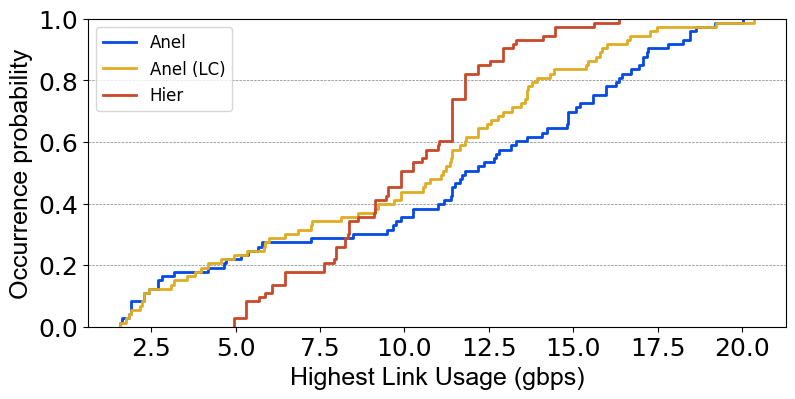

In [84]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# ---------
# LINE PLOT
# ---------

t1_net = []
t1_lc_net = []
t2_net = []

for timestamp in range(0, 73):
    df_t1 = pandas.read_csv(r"solutions\T1_2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    df_t1_lc = pandas.read_csv(r"solutions\T1_LC_2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    df_t2 = pandas.read_csv(r"solutions\2160p\topo_50_time_{}_network.csv".format(timestamp), sep=',')
    
    t1_net.append(df_t1['usage'].max())
    t1_lc_net.append(df_t1_lc['usage'].max())
    t2_net.append(df_t2['usage'].max())

fig, ax1 = plt.subplots(figsize=(9, 4))

color1 = '#643299'
color2 = '#054AE3'
color3 = '#C84929'
color4 = '#DFAD23'
color5 = '#55AF01'

alpha = 0.7
ax1.set_ylabel('Occurrence probability', fontsize=18, fontfamily='Arial')
ax1.set_xlabel('Highest Link Usage (gbps)', fontsize=18, fontfamily='Arial')
ax1.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.tick_params(axis='x', which='major', labelsize=18)

ax1.ecdf(t1_net, color=color2, lw=2, label='Anel')
ax1.ecdf(t1_lc_net, color=color4, lw=2, label='Anel (LC)')
ax1.ecdf(t2_net, color=color3, lw=2, label='Hier')

# plt.yticks([92, 93, 94, 95, 96])
# plt.xticks(range(0, 74, 12))
plt.legend(loc='upper left', fontsize=12)

# plt.savefig('fig/centralization_service.pdf', bbox_inches='tight')
